#### setup environment

In [1]:
import sys
sys.executable

'/home/zb609/anaconda2/envs/python-mm-27/bin/python'

In [2]:
from os import path, environ
import logging
import numpy as np
from matplotlib import pyplot as plt

from madminer.sampling import SampleAugmenter, benchmark, benchmarks
from madminer.ml import ParameterizedRatioEstimator
from madminer.plotting.distributions import plot_distributions

from batch_madminer_event_runner import EventRunner
%matplotlib inline

# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.DEBUG)



working_dir = '/scratch/zb609/madminer_data_higgs4l' # cluster
# working_dir = '/scratch/madminer_data' # my computer

er = EventRunner(working_dir)

batch_madminer_event_runner.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/zb609/anaconda2/envs/python-mm-27/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/zb609/anaconda2/envs/python-mm-27/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/zb609/anaconda2/envs/python-mm-27/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zb609/anaconda2/envs/python-mm-27/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/zb609/anaconda2/envs/python-mm-27/lib/python2.7

16:05 madminer.analysis.da INFO    Loading data from /scratch/zb609/madminer_data_higgs4l/data/miner_lhe_data_shuffled.h5
16:05 madminer.analysis.da INFO    Found 1 parameters
16:05 madminer.analysis.da DEBUG      HIGGS_WIDTH (LHA: DECAY 25, maximal power in squared ME: (2,), range: (0.0, 1.0))
16:05 madminer.analysis.da INFO    Did not find nuisance parameters
16:05 madminer.analysis.da INFO    Found 23 benchmarks, of which 23 physical
16:05 madminer.analysis.da DEBUG      126_1.0E-05: HIGGS_WIDTH = -5.00e+00
16:05 madminer.analysis.da DEBUG      126_1.8E-05: HIGGS_WIDTH = -4.73e+00
16:05 madminer.analysis.da DEBUG      126_3.4E-05: HIGGS_WIDTH = -4.47e+00
16:05 madminer.analysis.da DEBUG      126_6.2E-05: HIGGS_WIDTH = -4.20e+00
16:05 madminer.analysis.da DEBUG      126_1.1E-04: HIGGS_WIDTH = -3.94e+00
16:05 madminer.analysis.da DEBUG      126_2.1E-04: HIGGS_WIDTH = -3.67e+00
16:05 madminer.analysis.da DEBUG      126_3.9E-04: HIGGS_WIDTH = -3.41e+00
16:05 madminer.analysis.da DEBUG  

16:05 madminer.sampling.sa DEBUG   Starting sample extraction
16:05 madminer.sampling.sa INFO    Starting sampling serially
16:05 madminer.sampling.sa DEBUG   Will print training progress every 1 sets
16:05 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
16:05 madminer.sampling.sa DEBUG   Drawing 500 events for the following parameter points:
16:05 madminer.sampling.sa DEBUG     0: theta = [-5.], nu = None
16:05 madminer.sampling.sa DEBUG     1: theta = [0.], nu = None (sampling)
16:05 madminer.analysis.da DEBUG   Calculating cross sections for thetas = ['126_1.0E-05', '126_1.0E+00'] and nus = [None, None]
16:05 madminer.analysis.da DEBUG   Sampling benchmark closest to [0.]: 21
16:05 madminer.analysis.da DEBUG   xsecs and uncertainties [pb]:
16:05 madminer.analysis.da DEBUG     (40.945942 +/- 15.030731) pb (36.708720 %)
16:05 madminer.analysis.da DEBUG     (0.000259 +/- 0.000000) pb (0.186750 %)
16:05 madminer.sampling.sa DEBUG   Sampling from partition test, using we

16:05 madminer.ml.base     INFO    Loading model from /scratch/zb609/madminer_data_higgs4l/models/alice
16:05 madminer.ml.base     DEBUG   Loading settings from /scratch/zb609/madminer_data_higgs4l/models/alice_settings.json
16:05 madminer.ml.base     DEBUG     Found input scaling information: means [ 8.13767929e+01  2.36117973e+01  8.99165869e-04  1.43314386e-03
  8.12788467e+01  2.36140633e+01  9.59983561e-04 -3.75238247e-04
  8.12546082e+01  2.36162510e+01  9.69730667e-04 -1.22623343e-03
  8.12298813e+01  2.36315517e+01  1.22559431e-03  3.24493798e-04
  4.75130424e+01  4.75132065e+01  1.08221725e+02], stds [130.93143    14.133527    1.7171423   1.7812237 131.20996    14.1315365
   1.7163138   1.7807142 130.86316    14.123543    1.7162219   1.7807684
 130.35208    14.129049    1.7157536   1.7826493  32.80032    32.789547
  17.55192  ]
16:05 madminer.ml.base     DEBUG   Loading state dictionary from /scratch/zb609/madminer_data_higgs4l/models/alice_state_dict.pt
16:05 madminer.ml.base

16:05 madminer.sampling.sa DEBUG   Starting sample extraction
16:05 madminer.sampling.sa INFO    Starting sampling serially
16:05 madminer.sampling.sa DEBUG   Will print training progress every 1 sets
16:05 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
16:05 madminer.sampling.sa DEBUG   Drawing 500 events for the following parameter points:
16:05 madminer.sampling.sa DEBUG     0: theta = [-3.939794], nu = None
16:05 madminer.sampling.sa DEBUG     1: theta = [0.], nu = None (sampling)
16:05 madminer.analysis.da DEBUG   Calculating cross sections for thetas = ['126_1.1E-04', '126_1.0E+00'] and nus = [None, None]
16:05 madminer.analysis.da DEBUG   Sampling benchmark closest to [0.]: 21
16:05 madminer.analysis.da DEBUG   xsecs and uncertainties [pb]:
16:05 madminer.analysis.da DEBUG     (2.522741 +/- 0.297186) pb (11.780300 %)
16:05 madminer.analysis.da DEBUG     (0.000259 +/- 0.000000) pb (0.186750 %)
16:05 madminer.sampling.sa DEBUG   Sampling from partition test, usin

16:05 madminer.ml.base     INFO    Loading model from /scratch/zb609/madminer_data_higgs4l/models/alice
16:05 madminer.ml.base     DEBUG   Loading settings from /scratch/zb609/madminer_data_higgs4l/models/alice_settings.json
16:05 madminer.ml.base     DEBUG     Found input scaling information: means [ 8.13767929e+01  2.36117973e+01  8.99165869e-04  1.43314386e-03
  8.12788467e+01  2.36140633e+01  9.59983561e-04 -3.75238247e-04
  8.12546082e+01  2.36162510e+01  9.69730667e-04 -1.22623343e-03
  8.12298813e+01  2.36315517e+01  1.22559431e-03  3.24493798e-04
  4.75130424e+01  4.75132065e+01  1.08221725e+02], stds [130.93143    14.133527    1.7171423   1.7812237 131.20996    14.1315365
   1.7163138   1.7807142 130.86316    14.123543    1.7162219   1.7807684
 130.35208    14.129049    1.7157536   1.7826493  32.80032    32.789547
  17.55192  ]
16:05 madminer.ml.base     DEBUG   Loading state dictionary from /scratch/zb609/madminer_data_higgs4l/models/alice_state_dict.pt
16:05 madminer.ml.base

16:05 madminer.sampling.sa DEBUG   Starting sample extraction
16:05 madminer.sampling.sa INFO    Starting sampling serially
16:05 madminer.sampling.sa DEBUG   Will print training progress every 1 sets
16:05 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
16:05 madminer.sampling.sa DEBUG   Drawing 500 events for the following parameter points:
16:05 madminer.sampling.sa DEBUG     0: theta = [-2.879588], nu = None
16:05 madminer.sampling.sa DEBUG     1: theta = [0.], nu = None (sampling)
16:05 madminer.analysis.da DEBUG   Calculating cross sections for thetas = ['126_1.3E-03', '126_1.0E+00'] and nus = [None, None]
16:05 madminer.analysis.da DEBUG   Sampling benchmark closest to [0.]: 21
16:05 madminer.analysis.da DEBUG   xsecs and uncertainties [pb]:
16:05 madminer.analysis.da DEBUG     (0.214829 +/- 0.007439) pb (3.462668 %)
16:05 madminer.analysis.da DEBUG     (0.000259 +/- 0.000000) pb (0.186750 %)
16:05 madminer.sampling.sa DEBUG   Sampling from partition test, using

16:05 madminer.ml.base     INFO    Loading model from /scratch/zb609/madminer_data_higgs4l/models/alice
16:05 madminer.ml.base     DEBUG   Loading settings from /scratch/zb609/madminer_data_higgs4l/models/alice_settings.json
16:05 madminer.ml.base     DEBUG     Found input scaling information: means [ 8.13767929e+01  2.36117973e+01  8.99165869e-04  1.43314386e-03
  8.12788467e+01  2.36140633e+01  9.59983561e-04 -3.75238247e-04
  8.12546082e+01  2.36162510e+01  9.69730667e-04 -1.22623343e-03
  8.12298813e+01  2.36315517e+01  1.22559431e-03  3.24493798e-04
  4.75130424e+01  4.75132065e+01  1.08221725e+02], stds [130.93143    14.133527    1.7171423   1.7812237 131.20996    14.1315365
   1.7163138   1.7807142 130.86316    14.123543    1.7162219   1.7807684
 130.35208    14.129049    1.7157536   1.7826493  32.80032    32.789547
  17.55192  ]
16:05 madminer.ml.base     DEBUG   Loading state dictionary from /scratch/zb609/madminer_data_higgs4l/models/alice_state_dict.pt
16:05 madminer.ml.base

16:05 madminer.sampling.sa DEBUG   Starting sample extraction
16:05 madminer.sampling.sa INFO    Starting sampling serially
16:05 madminer.sampling.sa DEBUG   Will print training progress every 1 sets
16:05 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
16:05 madminer.sampling.sa DEBUG   Drawing 500 events for the following parameter points:
16:05 madminer.sampling.sa DEBUG     0: theta = [-1.819382], nu = None
16:05 madminer.sampling.sa DEBUG     1: theta = [0.], nu = None (sampling)
16:05 madminer.analysis.da DEBUG   Calculating cross sections for thetas = ['126_1.5E-02', '126_1.0E+00'] and nus = [None, None]
16:05 madminer.analysis.da DEBUG   Sampling benchmark closest to [0.]: 21
16:05 madminer.analysis.da DEBUG   xsecs and uncertainties [pb]:
16:05 madminer.analysis.da DEBUG     (0.018482 +/- 0.000192) pb (1.036513 %)
16:05 madminer.analysis.da DEBUG     (0.000259 +/- 0.000000) pb (0.186750 %)
16:05 madminer.sampling.sa DEBUG   Sampling from partition test, using

16:05 madminer.ml.base     INFO    Loading model from /scratch/zb609/madminer_data_higgs4l/models/alice
16:05 madminer.ml.base     DEBUG   Loading settings from /scratch/zb609/madminer_data_higgs4l/models/alice_settings.json
16:05 madminer.ml.base     DEBUG     Found input scaling information: means [ 8.13767929e+01  2.36117973e+01  8.99165869e-04  1.43314386e-03
  8.12788467e+01  2.36140633e+01  9.59983561e-04 -3.75238247e-04
  8.12546082e+01  2.36162510e+01  9.69730667e-04 -1.22623343e-03
  8.12298813e+01  2.36315517e+01  1.22559431e-03  3.24493798e-04
  4.75130424e+01  4.75132065e+01  1.08221725e+02], stds [130.93143    14.133527    1.7171423   1.7812237 131.20996    14.1315365
   1.7163138   1.7807142 130.86316    14.123543    1.7162219   1.7807684
 130.35208    14.129049    1.7157536   1.7826493  32.80032    32.789547
  17.55192  ]
16:05 madminer.ml.base     DEBUG   Loading state dictionary from /scratch/zb609/madminer_data_higgs4l/models/alice_state_dict.pt
16:05 madminer.ml.base

16:05 madminer.sampling.sa DEBUG   Starting sample extraction
16:05 madminer.sampling.sa INFO    Starting sampling serially
16:05 madminer.sampling.sa DEBUG   Will print training progress every 1 sets
16:05 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
16:05 madminer.sampling.sa DEBUG   Drawing 500 events for the following parameter points:
16:05 madminer.sampling.sa DEBUG     0: theta = [-0.759176], nu = None
16:05 madminer.sampling.sa DEBUG     1: theta = [0.], nu = None (sampling)
16:05 madminer.analysis.da DEBUG   Calculating cross sections for thetas = ['126_1.7E-01', '126_1.0E+00'] and nus = [None, None]
16:05 madminer.analysis.da DEBUG   Sampling benchmark closest to [0.]: 21
16:05 madminer.analysis.da DEBUG   xsecs and uncertainties [pb]:
16:05 madminer.analysis.da DEBUG     (0.001566 +/- 0.000005) pb (0.315073 %)
16:05 madminer.analysis.da DEBUG     (0.000259 +/- 0.000000) pb (0.186750 %)
16:05 madminer.sampling.sa DEBUG   Sampling from partition test, using

16:05 madminer.ml.base     INFO    Loading model from /scratch/zb609/madminer_data_higgs4l/models/alice
16:05 madminer.ml.base     DEBUG   Loading settings from /scratch/zb609/madminer_data_higgs4l/models/alice_settings.json
16:05 madminer.ml.base     DEBUG     Found input scaling information: means [ 8.13767929e+01  2.36117973e+01  8.99165869e-04  1.43314386e-03
  8.12788467e+01  2.36140633e+01  9.59983561e-04 -3.75238247e-04
  8.12546082e+01  2.36162510e+01  9.69730667e-04 -1.22623343e-03
  8.12298813e+01  2.36315517e+01  1.22559431e-03  3.24493798e-04
  4.75130424e+01  4.75132065e+01  1.08221725e+02], stds [130.93143    14.133527    1.7171423   1.7812237 131.20996    14.1315365
   1.7163138   1.7807142 130.86316    14.123543    1.7162219   1.7807684
 130.35208    14.129049    1.7157536   1.7826493  32.80032    32.789547
  17.55192  ]
16:05 madminer.ml.base     DEBUG   Loading state dictionary from /scratch/zb609/madminer_data_higgs4l/models/alice_state_dict.pt
16:05 madminer.ml.base

16:05 madminer.sampling.sa DEBUG   Starting sample extraction
16:05 madminer.sampling.sa INFO    Starting sampling serially
16:05 madminer.sampling.sa DEBUG   Will print training progress every 1 sets
16:05 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
16:05 madminer.sampling.sa DEBUG   Drawing 500 events for the following parameter points:
16:05 madminer.sampling.sa DEBUG     0: theta = [0.30103], nu = None
16:05 madminer.sampling.sa DEBUG     1: theta = [0.], nu = None (sampling)
16:05 madminer.analysis.da DEBUG   Calculating cross sections for thetas = ['126_2.0E+00', '126_1.0E+00'] and nus = [None, None]
16:05 madminer.analysis.da DEBUG   Sampling benchmark closest to [0.]: 21
16:05 madminer.analysis.da DEBUG   xsecs and uncertainties [pb]:
16:05 madminer.analysis.da DEBUG     (0.000122 +/- 0.000000) pb (0.206991 %)
16:05 madminer.analysis.da DEBUG     (0.000259 +/- 0.000000) pb (0.186750 %)
16:05 madminer.sampling.sa DEBUG   Sampling from partition test, using w

16:06 madminer.ml.base     INFO    Loading model from /scratch/zb609/madminer_data_higgs4l/models/alice
16:06 madminer.ml.base     DEBUG   Loading settings from /scratch/zb609/madminer_data_higgs4l/models/alice_settings.json
16:06 madminer.ml.base     DEBUG     Found input scaling information: means [ 8.13767929e+01  2.36117973e+01  8.99165869e-04  1.43314386e-03
  8.12788467e+01  2.36140633e+01  9.59983561e-04 -3.75238247e-04
  8.12546082e+01  2.36162510e+01  9.69730667e-04 -1.22623343e-03
  8.12298813e+01  2.36315517e+01  1.22559431e-03  3.24493798e-04
  4.75130424e+01  4.75132065e+01  1.08221725e+02], stds [130.93143    14.133527    1.7171423   1.7812237 131.20996    14.1315365
   1.7163138   1.7807142 130.86316    14.123543    1.7162219   1.7807684
 130.35208    14.129049    1.7157536   1.7826493  32.80032    32.789547
  17.55192  ]
16:06 madminer.ml.base     DEBUG   Loading state dictionary from /scratch/zb609/madminer_data_higgs4l/models/alice_state_dict.pt
16:06 madminer.ml.base

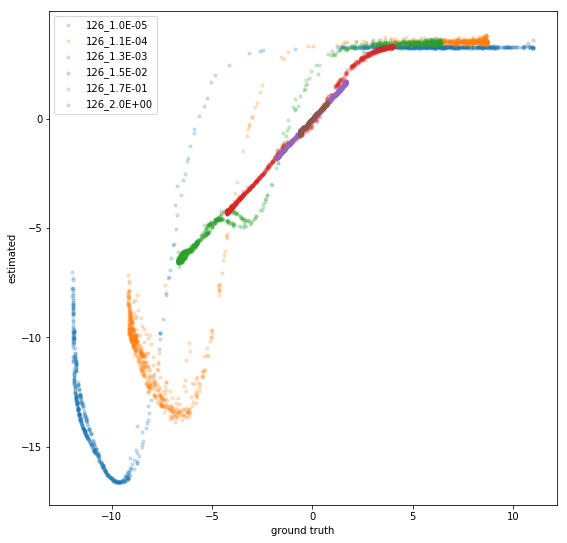

In [3]:
# load sample augmenter
n_test_events = 1000
miner_data_shuffled_path = path.join(er.data_dir, 'data/miner_lhe_data_shuffled.h5')
sa = SampleAugmenter(miner_data_shuffled_path)
n_benchmarks = len(er.theta0_benchmarks)
theta0_benchmarks_sublist = er.theta0_benchmarks[0::4]
fig = plt.figure(figsize=(20,20))
fig2 = plt.figure(figsize=(15,25))

ax1 = fig.add_subplot(221)

for idx, theta0_benchmark in enumerate(theta0_benchmarks_sublist):
    test_result = sa.sample_train_ratio(
        theta0=benchmark(theta0_benchmark.name),
        theta1=benchmark(er.theta1_benchmark.name),
        n_samples=n_test_events,
        sample_only_from_closest_benchmark=True,
        partition='test',
        folder=path.join(er.data_dir, 'data/samples'),
        filename='test_truth',
    )
    x, theta0, theta1, y, r_xz, t_xz, n_effective = test_result
    m4l = np.log(x[:,-1])
    ground_truth_log_likelihood_ratio = np.log(r_xz)

    ratio_estimator = ParameterizedRatioEstimator(n_hidden=(100, 100))
    ratio_estimator.load(path.join(er.data_dir, 'models/alice'))

    estimated_log_likelihood_ratio, _ = ratio_estimator.evaluate_log_likelihood_ratio(
        # x=path.join(er.data_dir, 'data/samples/x_test_truth.npy'),
        x=x,
        theta=theta0,
        test_all_combinations=False
    )

    ax1.scatter(ground_truth_log_likelihood_ratio, estimated_log_likelihood_ratio, s=10, alpha=0.2, label=theta0_benchmark.name)
    ax2 = fig2.add_subplot(len(theta0_benchmarks_sublist)/2 + 1, 2, 1+idx)
    ax2.scatter(m4l, ground_truth_log_likelihood_ratio, s=10, alpha=0.2, c='g', label='truth')
    ax2.scatter(m4l, estimated_log_likelihood_ratio, s=10, alpha=0.2, c='b', label='estimated')
    ax2.set_title(theta0_benchmark.name)
    ax2.set_xlabel('log(m4l)')
    ax2.set_ylabel('log likelihood ratio')
    ax2.legend()

ax1.set_xlabel('ground truth')
ax1.set_ylabel('estimated')
ax1.legend()
plt.close(fig)
plt.close(fig2)
fig


16:06 matplotlib.font_mana DEBUG   findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans (u'/home/zb609/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


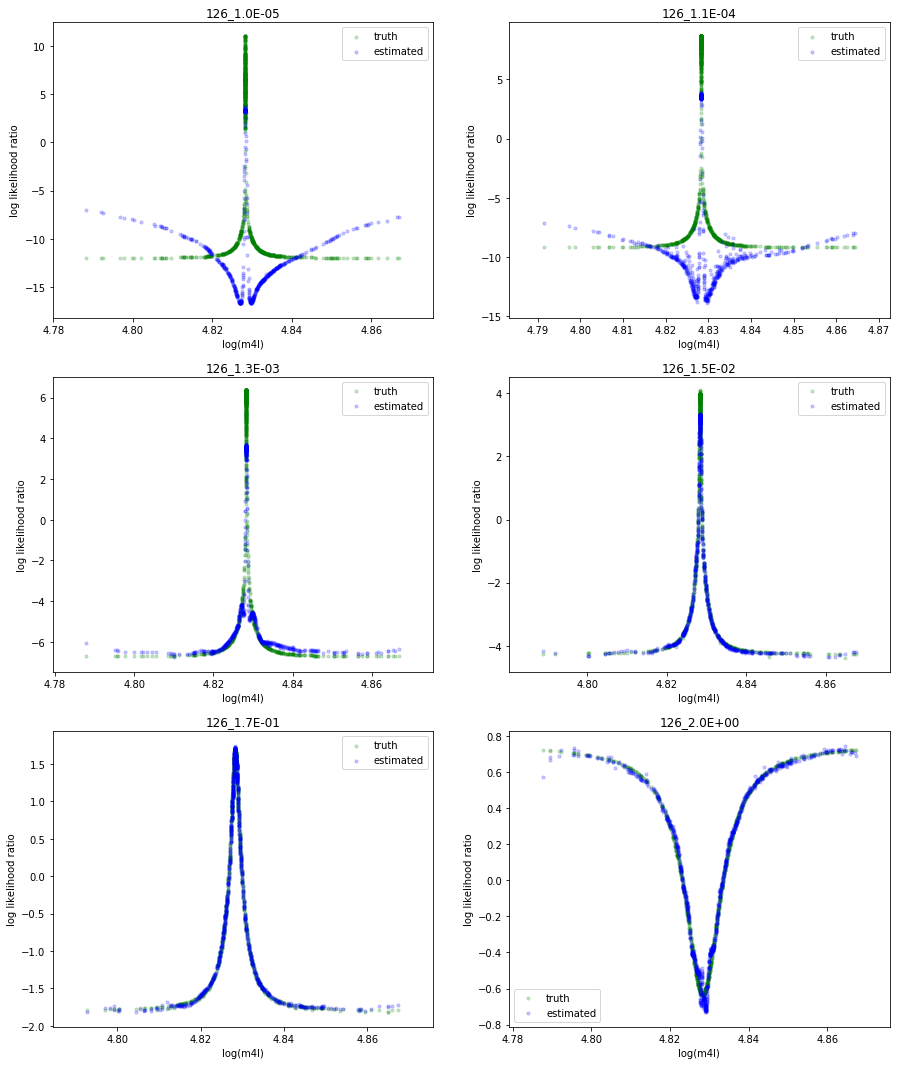

In [4]:
fig2

16:06 madminer.sampling.sa INFO    Extracting training sample for ratio-based methods. Numerator hypothesis: 21 benchmarks, starting with ['126_1.0E-05', '126_1.8E-05', '126_3.4E-05'], denominator hypothesis: 126_1.0E+00
16:06 root                 WARNING No morphing setup loaded. Cannot calculate joint score.
16:06 madminer.sampling.sa DEBUG   Starting sample extraction
16:06 madminer.sampling.sa INFO    Starting sampling serially
16:06 madminer.sampling.sa DEBUG   Will print training progress every 1 sets
16:06 madminer.sampling.sa INFO    Sampling from parameter point 1 / 21
16:06 madminer.sampling.sa DEBUG   Drawing 24 events for the following parameter points:
16:06 madminer.sampling.sa DEBUG     0: theta = [-5.], nu = None (sampling)
16:06 madminer.sampling.sa DEBUG     1: theta = [0.], nu = None
16:06 madminer.analysis.da DEBUG   Calculating cross sections for thetas = ['126_1.0E-05', '126_1.0E+00'] and nus = [None, None]
16:06 madminer.analysis.da DEBUG   Sampling benchmark clo

16:06 madminer.analysis.da DEBUG   Sampling benchmark closest to [-3.1446395]: 7
16:06 madminer.analysis.da DEBUG   xsecs and uncertainties [pb]:
16:06 madminer.analysis.da DEBUG     (0.403059 +/- 0.000759) pb (0.188426 %)
16:06 madminer.analysis.da DEBUG     (0.000199 +/- 0.000009) pb (4.407039 %)
16:06 madminer.sampling.sa DEBUG   Sampling from partition test, using weighted events 26727632 to None and a correction factor 5.0
16:06 madminer.analysis.da DEBUG   Sampling benchmark closest to [-3.1446395]: 7
16:06 madminer.sampling.sa DEBUG     Cumulative probability (should be close to 1): 0.9876612928218316
16:06 madminer.sampling.sa INFO    Sampling from parameter point 9 / 21
16:06 madminer.sampling.sa DEBUG   Drawing 24 events for the following parameter points:
16:06 madminer.sampling.sa DEBUG     0: theta = [-2.879588], nu = None (sampling)
16:06 madminer.sampling.sa DEBUG     1: theta = [0.], nu = None
16:06 madminer.analysis.da DEBUG   Calculating cross sections for thetas = ['

16:06 madminer.sampling.sa DEBUG     1: theta = [0.], nu = None
16:06 madminer.analysis.da DEBUG   Calculating cross sections for thetas = ['126_9.5E-02', '126_1.0E+00'] and nus = [None, None]
16:06 madminer.analysis.da DEBUG   Sampling benchmark closest to [-1.0242275]: 15
16:06 madminer.analysis.da DEBUG   xsecs and uncertainties [pb]:
16:06 madminer.analysis.da DEBUG     (0.003026 +/- 0.000009) pb (0.285954 %)
16:06 madminer.analysis.da DEBUG     (0.000249 +/- 0.000002) pb (0.664569 %)
16:06 madminer.sampling.sa DEBUG   Sampling from partition test, using weighted events 26727632 to None and a correction factor 5.0
16:06 madminer.analysis.da DEBUG   Sampling benchmark closest to [-1.0242275]: 15
16:06 madminer.sampling.sa DEBUG     Cumulative probability (should be close to 1): 0.9278629619354456
16:06 madminer.sampling.sa INFO    Sampling from parameter point 17 / 21
16:06 madminer.sampling.sa DEBUG   Drawing 24 events for the following parameter points:
16:06 madminer.sampling.sa 

16:06 madminer.sampling.sa DEBUG   Starting sample extraction
16:06 madminer.sampling.sa INFO    Starting sampling serially
16:06 madminer.sampling.sa DEBUG   Will print training progress every 1 sets
16:06 madminer.sampling.sa INFO    Sampling from parameter point 1 / 21
16:06 madminer.sampling.sa DEBUG   Drawing 24 events for the following parameter points:
16:06 madminer.sampling.sa DEBUG     0: theta = [-5.], nu = None
16:06 madminer.sampling.sa DEBUG     1: theta = [0.], nu = None (sampling)
16:06 madminer.analysis.da DEBUG   Calculating cross sections for thetas = ['126_1.0E-05', '126_1.0E+00'] and nus = [None, None]
16:06 madminer.analysis.da DEBUG   Sampling benchmark closest to [0.]: 21
16:06 madminer.analysis.da DEBUG   xsecs and uncertainties [pb]:
16:06 madminer.analysis.da DEBUG     (40.945942 +/- 15.030731) pb (36.708720 %)
16:06 madminer.analysis.da DEBUG     (0.000259 +/- 0.000000) pb (0.186750 %)
16:06 madminer.sampling.sa DEBUG   Sampling from partition test, using we

16:07 madminer.sampling.sa DEBUG   Sampling from partition test, using weighted events 26727632 to None and a correction factor 5.0
16:07 madminer.analysis.da DEBUG   Sampling benchmark closest to [0.]: 21
16:07 madminer.sampling.sa DEBUG     Cumulative probability (should be close to 1): 0.9999999999999934
16:07 madminer.sampling.sa INFO    Sampling from parameter point 9 / 21
16:07 madminer.sampling.sa DEBUG   Drawing 24 events for the following parameter points:
16:07 madminer.sampling.sa DEBUG     0: theta = [-2.879588], nu = None
16:07 madminer.sampling.sa DEBUG     1: theta = [0.], nu = None (sampling)
16:07 madminer.analysis.da DEBUG   Calculating cross sections for thetas = ['126_1.3E-03', '126_1.0E+00'] and nus = [None, None]
16:07 madminer.analysis.da DEBUG   Sampling benchmark closest to [0.]: 21
16:07 madminer.analysis.da DEBUG   xsecs and uncertainties [pb]:
16:07 madminer.analysis.da DEBUG     (0.214829 +/- 0.007439) pb (3.462668 %)
16:07 madminer.analysis.da DEBUG     (0

16:07 madminer.analysis.da DEBUG     (0.000259 +/- 0.000000) pb (0.186750 %)
16:07 madminer.sampling.sa DEBUG   Sampling from partition test, using weighted events 26727632 to None and a correction factor 5.0
16:07 madminer.analysis.da DEBUG   Sampling benchmark closest to [0.]: 21
16:07 madminer.sampling.sa DEBUG     Cumulative probability (should be close to 1): 0.9879645088439433
16:07 madminer.sampling.sa INFO    Sampling from parameter point 17 / 21
16:07 madminer.sampling.sa DEBUG   Drawing 24 events for the following parameter points:
16:07 madminer.sampling.sa DEBUG     0: theta = [-0.759176], nu = None
16:07 madminer.sampling.sa DEBUG     1: theta = [0.], nu = None (sampling)
16:07 madminer.analysis.da DEBUG   Calculating cross sections for thetas = ['126_1.7E-01', '126_1.0E+00'] and nus = [None, None]
16:07 madminer.analysis.da DEBUG   Sampling benchmark closest to [0.]: 21
16:07 madminer.analysis.da DEBUG   xsecs and uncertainties [pb]:
16:07 madminer.analysis.da DEBUG     (

16:07 madminer.ml.base     INFO    Loading model from /scratch/zb609/madminer_data_higgs4l/models/alice
16:07 madminer.ml.base     DEBUG   Loading settings from /scratch/zb609/madminer_data_higgs4l/models/alice_settings.json
16:07 madminer.ml.base     DEBUG     Found input scaling information: means [ 8.13767929e+01  2.36117973e+01  8.99165869e-04  1.43314386e-03
  8.12788467e+01  2.36140633e+01  9.59983561e-04 -3.75238247e-04
  8.12546082e+01  2.36162510e+01  9.69730667e-04 -1.22623343e-03
  8.12298813e+01  2.36315517e+01  1.22559431e-03  3.24493798e-04
  4.75130424e+01  4.75132065e+01  1.08221725e+02], stds [130.93143    14.133527    1.7171423   1.7812237 131.20996    14.1315365
   1.7163138   1.7807142 130.86316    14.123543    1.7162219   1.7807684
 130.35208    14.129049    1.7157536   1.7826493  32.80032    32.789547
  17.55192  ]
16:07 madminer.ml.base     DEBUG   Loading state dictionary from /scratch/zb609/madminer_data_higgs4l/models/alice_state_dict.pt
16:07 madminer.ml.base

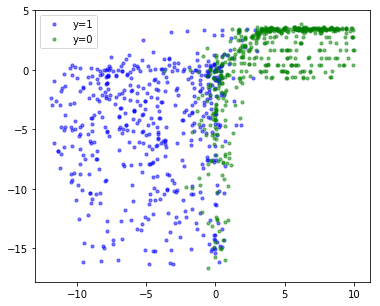

In [5]:
# plot two series based on values of y
test_result = sa.sample_train_ratio(
    theta0=benchmarks([b.name for b in er.theta0_benchmarks]),
    theta1=benchmark(er.theta1_benchmark.name),
    n_samples=n_test_events,
    sample_only_from_closest_benchmark=True,
    partition='test',
    folder=path.join(er.data_dir, 'data/samples'),
    filename='test_truth',
)
x, theta0, theta1, y, r_xz, t_xz, n_effective = test_result

ground_truth_log_likelihood_ratio_y_1 = np.log(r_xz[np.array(y[:, 0], dtype=bool)])
ground_truth_log_likelihood_ratio_y_0 = np.log(r_xz[np.array(0**y[:, 0], dtype=bool)])
x_y_1 = x[np.array(y[:, 0], dtype=bool)]
x_y_0 = x[np.array(0**y[:, 0], dtype=bool)]

ratio_estimator = ParameterizedRatioEstimator(n_hidden=(100, 100))
ratio_estimator.load(path.join(er.data_dir, 'models/alice'))

estimated_log_likelihood_ratio_y_1, _ = ratio_estimator.evaluate_log_likelihood_ratio(
    # x=path.join(er.data_dir, 'data/samples/x_test_truth.npy'),
    x=x_y_1,
    theta=theta0,
    test_all_combinations=False
)

estimated_log_likelihood_ratio_y_0, _ = ratio_estimator.evaluate_log_likelihood_ratio(
    # x=path.join(er.data_dir, 'data/samples/x_test_truth.npy'),
    x=x_y_0,
    theta=theta0,
    test_all_combinations=False
)

fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(111)
ax1.scatter(ground_truth_log_likelihood_ratio_y_1, estimated_log_likelihood_ratio_y_1, s=10, alpha=0.5, c='b', label='y=1')
ax1.scatter(ground_truth_log_likelihood_ratio_y_0, estimated_log_likelihood_ratio_y_0, s=10, alpha=0.5, c='g', label='y=0')
plt.legend()
plt.show()

In [6]:
theta0_benchmarks_sublist

[Benchmark(mass=126.0, width=1e-05, width_exp=-5.0, name='126_1.0E-05'),
 Benchmark(mass=126.0, width=0.00011486983549970352, width_exp=-3.9397940008672037, name='126_1.1E-04'),
 Benchmark(mass=126.0, width=0.001319507910772895, width_exp=-2.8795880017344073, name='126_1.3E-03'),
 Benchmark(mass=126.0, width=0.015157165665103991, width_exp=-1.819382002601611, name='126_1.5E-02'),
 Benchmark(mass=126.0, width=0.174110112659225, width_exp=-0.7591760034688146, name='126_1.7E-01'),
 Benchmark(mass=126.0, width=2.0, width_exp=0.3010299956639812, name='126_2.0E+00')]

16:07 madminer.analysis.da INFO    Loading data from /scratch/zb609/madminer_data_higgs4l/data/miner_lhe_data_shuffled.h5
16:07 madminer.analysis.da INFO    Found 1 parameters
16:07 madminer.analysis.da DEBUG      HIGGS_WIDTH (LHA: DECAY 25, maximal power in squared ME: (2,), range: (0.0, 1.0))
16:07 madminer.analysis.da INFO    Did not find nuisance parameters
16:07 madminer.analysis.da INFO    Found 23 benchmarks, of which 23 physical
16:07 madminer.analysis.da DEBUG      126_1.0E-05: HIGGS_WIDTH = -5.00e+00
16:07 madminer.analysis.da DEBUG      126_1.8E-05: HIGGS_WIDTH = -4.73e+00
16:07 madminer.analysis.da DEBUG      126_3.4E-05: HIGGS_WIDTH = -4.47e+00
16:07 madminer.analysis.da DEBUG      126_6.2E-05: HIGGS_WIDTH = -4.20e+00
16:07 madminer.analysis.da DEBUG      126_1.1E-04: HIGGS_WIDTH = -3.94e+00
16:07 madminer.analysis.da DEBUG      126_2.1E-04: HIGGS_WIDTH = -3.67e+00
16:07 madminer.analysis.da DEBUG      126_3.9E-04: HIGGS_WIDTH = -3.41e+00
16:07 madminer.analysis.da DEBUG  

16:11 matplotlib.font_mana DEBUG   findfont: Matching :family=STIXSizeFiveSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXSizeFiveSym (u'/home/zb609/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf') with score of 0.050000
16:11 matplotlib.font_mana DEBUG   findfont: Matching :family=STIXSizeTwoSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXSizeTwoSym (u'/home/zb609/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf') with score of 0.050000
16:11 matplotlib.font_mana DEBUG   findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral (u'/home/zb609/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
16:11 matplotlib.font_mana DEBUG   findfont: Matching :family=STIXNonUnicode:style=italic:variant=normal:weight=normal:stretch=no

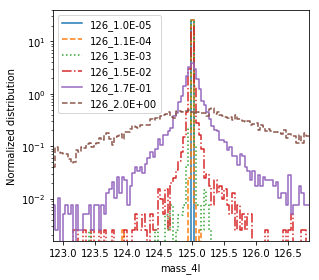

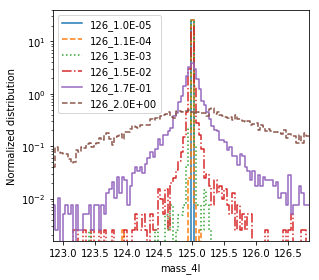

In [7]:
# plot_distributions(filename=miner_data_shuffled_path, log=True, observables=['mass_4l'], uncertainties='none', sample_only_from_closest_benchmark=True, normalize=True, n_bins=100, parameter_points=[b.name for b in theta0_benchmarks_sublist], n_events=10000)
plot_distributions(filename=miner_data_shuffled_path, log=True, observables=['mass_4l'], uncertainties='none', sample_only_from_closest_benchmark=True, normalize=True, n_bins=100, parameter_points=[b.name for b in theta0_benchmarks_sublist], n_events=10000)

In [8]:
# from os import path
# from matplotlib import pyplot as plt
# from madminer.plotting.distributions import plot_distributions
# from batch_madminer_event_runner import EventRunner

# working_dir = '/scratch/zb609/madminer_data_higgs4l'

# er = EventRunner(working_dir)
# miner_data_shuffled_path = path.join(er.data_dir, 'data/miner_lhe_data_shuffled.h5')
# theta0_benchmarks_sublist = er.theta0_benchmarks[0::4]
# plot_distributions(filename=miner_data_shuffled_path, log=True, observables=['mass_4l'], uncertainties='none', sample_only_from_closest_benchmark=True, normalize=True, n_bins=100, parameter_points=[b.name for b in theta0_benchmarks_sublist], n_events=10000)
# plt.tight_layout()
# plt.savefig('mass_4l_distribution.png', bbox_inches='tight')